In [1]:
import pandas as pd
import numpy as np
import riskfolio as rp
import yfinance as yf
import matplotlib.pyplot as plt

/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Read in data and set index as the date
df = pd.read_csv('yf_df.csv')
df.set_index('Date', inplace = True)
df.index = pd.to_datetime(df.index)
df

,BTC,ETH,XRP,DOGE,LINK
Date,,,,,
2020-05-11,8601.795898,185.912842,0.194064,0.002413,3.585065
2020-05-12,8804.477539,189.312500,0.197637,0.002463,3.692374
2020-05-13,9269.987305,199.193283,0.201480,0.002521,3.760424
2020-05-14,9733.721680,202.949097,0.203129,0.002574,3.799387
2020-05-15,9328.197266,195.622665,0.198911,0.002506,3.674653
...,...,...,...,...,...
2024-05-16,65231.582031,2945.131104,0.515698,0.149637,15.509692
2024-05-17,67051.875000,3094.118652,0.523804,0.155563,16.252932
2024-05-18,66940.804688,3122.948975,0.521390,0.153077,16.311008


In [3]:
#Setting benchmark as the S&P500
benchmark = yf.download('^GSPC', start = '2020-05-11', end = '2024-05-21')
benchmark = benchmark[('Adj Close')]
benchmark

[*********************100%%**********************]  1 of 1 completed


/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


Date
2020-05-11    2930.189941
2020-05-12    2870.120117
2020-05-13    2820.000000
2020-05-14    2852.500000
2020-05-15    2863.699951
                 ...     
2024-05-14    5246.680176
2024-05-15    5308.149902
2024-05-16    5297.100098
2024-05-17    5303.270020
2024-05-20    5308.129883
Name: Adj Close, Length: 1014, dtype: float64

In [4]:
#Get returns
returns = df.pct_change().dropna() #Overall returns for each asset
returns_bench = benchmark.pct_change().dropna()

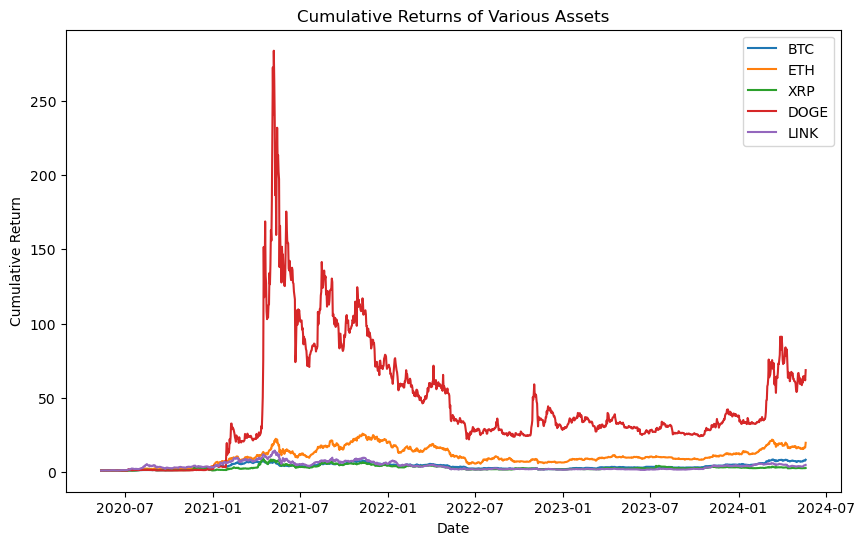

In [5]:
#Calculate the cumulative returns
cumulative_returns = (1 + returns).cumprod()

#Plot the cumulative returns
plt.figure(figsize=(10, 6))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

#Add title and labels
plt.title('Cumulative Returns of Various Assets')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

plt.show()

In [6]:
returns_bench

Date
2020-05-12   -0.020500
2020-05-13   -0.017463
2020-05-14    0.011525
2020-05-15    0.003926
2020-05-18    0.031501
                ...   
2024-05-14    0.004838
2024-05-15    0.011716
2024-05-16   -0.002082
2024-05-17    0.001165
2024-05-20    0.000916
Name: Adj Close, Length: 1013, dtype: float64

In [7]:
#Building portfolio object
port = rp.Portfolio(returns, nea = 4)

port.assets_stats(
    method_mu = 'hist', #Selected method to estimate expected returns based on historical data
    method_cov = 'hist', #Selected method to estimate covariance matrix based on historical data
    d = 0.94)

port.benchindex = returns_bench

In [8]:
#Estimate optimal portfolio for mean/cvar ratio
w = port.optimization(
    model = 'Classic', #Either classic, BL(Black Litterman), FM(Factor model), BLFM(Black Litterman w/Factor models)
    rm = 'CVaR', #Risk measure
    obj = 'Sharpe', #Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True, #Use historical scenarios for risk measures
    rf = 0, #Risk free rate
    l = 0) #Risk aversion factor, only useful when obj is 'utility'
w #Optimal weights for our portfolio

,weights
BTC,0.182915
ETH,0.197019
XRP,0.140741
DOGE,0.386362
LINK,0.092963


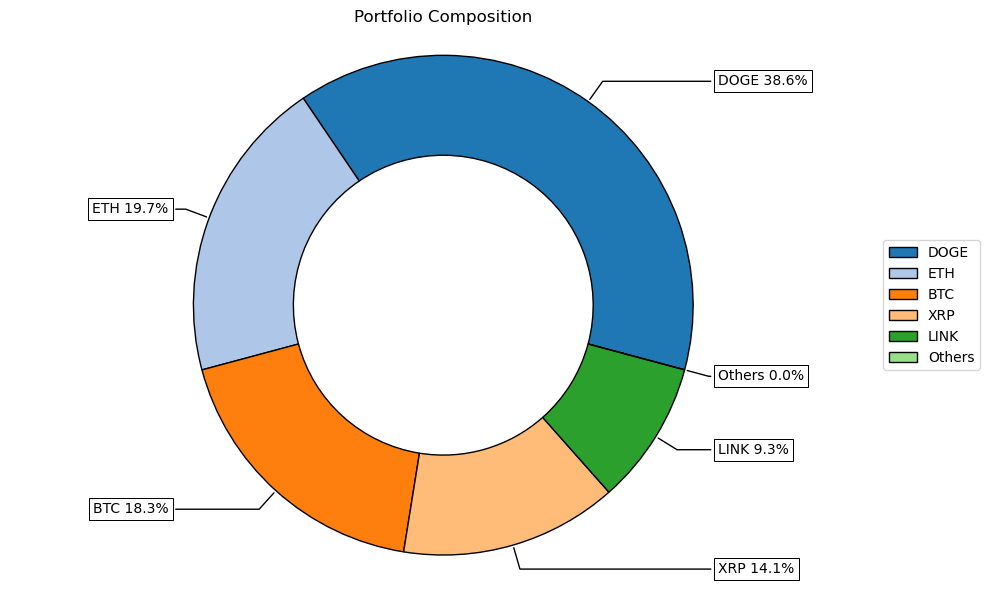

In [9]:
#Plotting optimal portfolio composition
ax = rp.plot_pie(
    w = w,
    others = 0.05,
    nrow = 25,
    cmap = 'tab20',
    height = 6,
    width = 10,
    ax = None)

In [10]:
#Calculate efficient frontier
points = 50

frontier = port.efficient_frontier(model = 'Classic',
                                   rm = 'CVaR',
                                   rf = 0,
                                   hist = True)

display(frontier.T.head())

,BTC,ETH,XRP,DOGE,LINK
0,0.367795,0.237384,0.186109,0.135650,0.073061
1,0.350658,0.240567,0.156395,0.206375,0.046005
2,0.338687,0.237021,0.148159,0.235628,0.040505
3,0.325511,0.235363,0.142132,0.258821,0.038173
4,0.312488,0.234800,0.135690,0.278004,0.039018


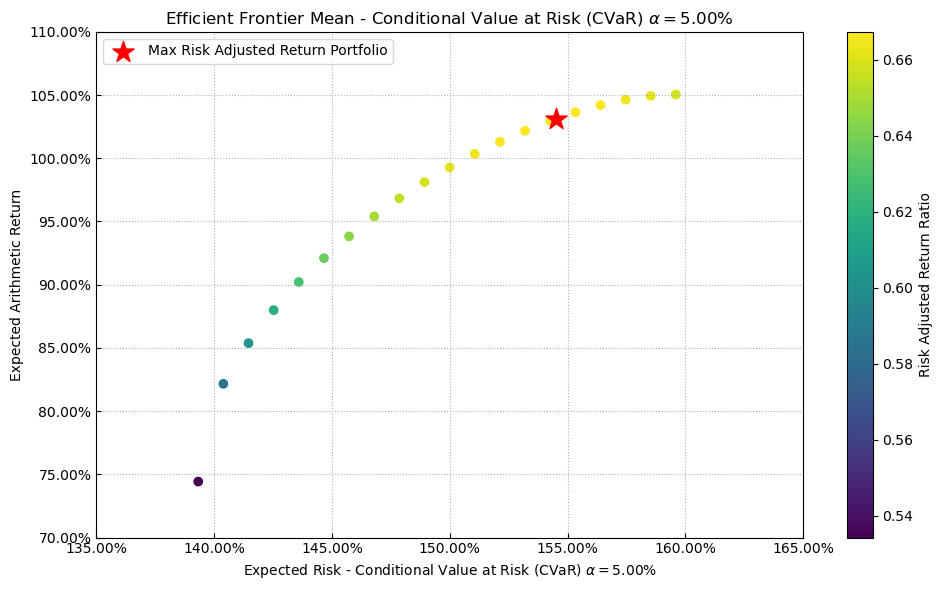

In [11]:
#Plot efficient frontier

ax = rp.plot_frontier(w_frontier = frontier,
                      mu = port.mu,
                      cov = port.cov,
                      returns = port.returns,
                      rm = 'CVaR',
                      rf = 0,
                      alpha = 0.05,
                      cmap = 'viridis',
                      w = w,
                      label = 'Max Risk Adjusted Return Portfolio',
                      marker = '*',
                      s = 16,
                      c = 'r',
                      height = 6,
                      width = 10,
                      ax = None
                      )

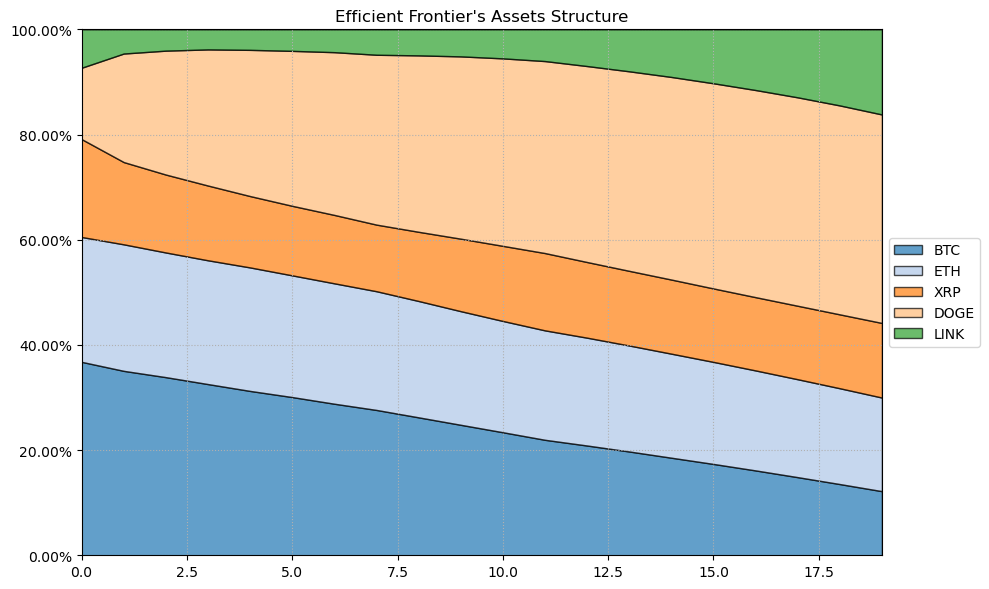

In [12]:
#Plot efficient frontier composition

ax = rp.plot_frontier_area(w_frontier = frontier,
                           cmap = 'tab20',
                           n_colors = 20,
                           height = 6,
                           width = 10,
                           ax = None)

<Axes: title={'center': 'Historical Compounded Cumulative Returns'}>

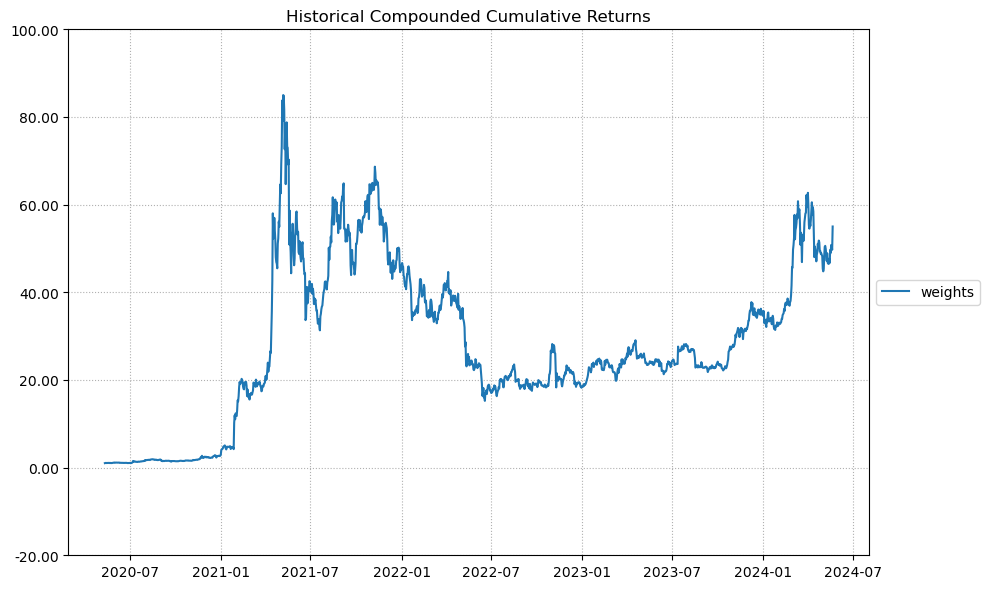

In [13]:
#Compounded returns
rp.plot_series(returns = returns, w = w)

array([<Axes: title={'center': 'Historical Compounded Cumulative Returns'}>,
       <Axes: title={'center': 'Historical Uncompounded Drawdown'}>],
      dtype=object)

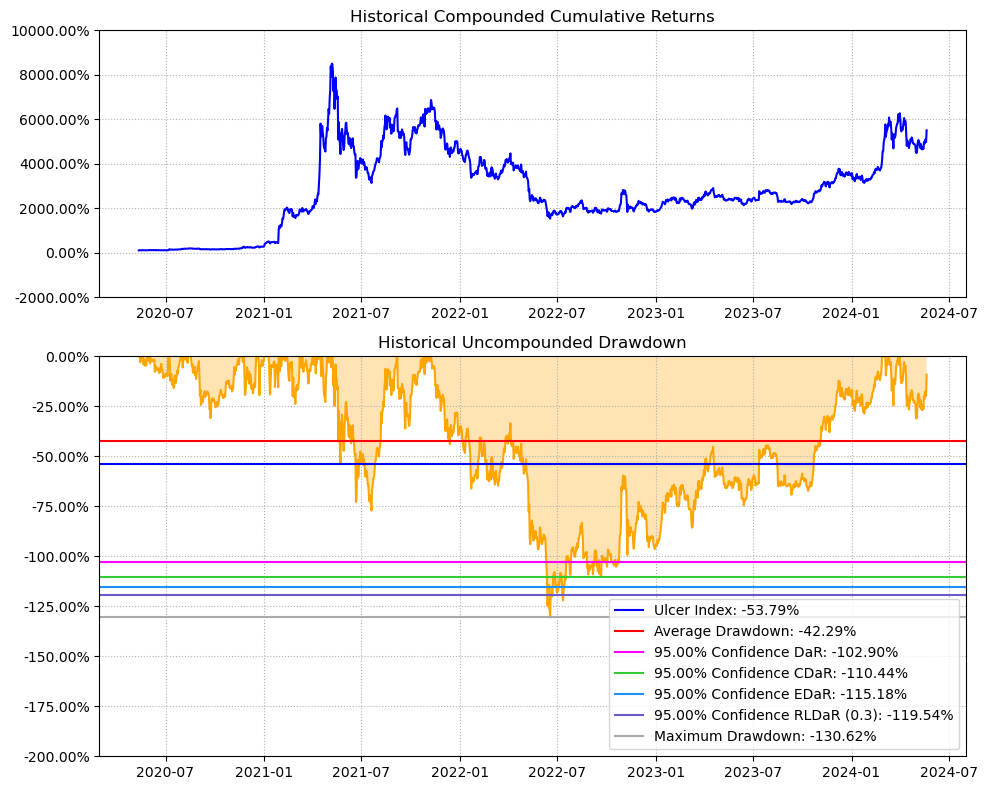

In [14]:
#Compounded returns + max drawdown
rp.plot_drawdown(returns, w)

In [15]:
returns.cumsum()

,BTC,ETH,XRP,DOGE,LINK
Date,,,,,
2020-05-12,0.023563,0.018286,0.018411,0.020721,0.029932
2020-05-13,0.076435,0.070479,0.037856,0.044270,0.048362
2020-05-14,0.126460,0.089334,0.046041,0.065293,0.058723
2020-05-15,0.084798,0.053235,0.025275,0.038875,0.025893
2020-05-16,0.090031,0.079072,0.030911,0.041668,0.049145
...,...,...,...,...,...
2024-05-16,2.807264,4.077050,3.361970,9.704750,3.800369
2024-05-17,2.835169,4.127638,3.377688,9.744353,3.848290
2024-05-18,2.833512,4.136956,3.373080,9.728372,3.851863


In [16]:
df.head()

,BTC,ETH,XRP,DOGE,LINK
Date,,,,,
2020-05-11,8601.795898,185.912842,0.194064,0.002413,3.585065
2020-05-12,8804.477539,189.312500,0.197637,0.002463,3.692374
2020-05-13,9269.987305,199.193283,0.201480,0.002521,3.760424
2020-05-14,9733.721680,202.949097,0.203129,0.002574,3.799387
2020-05-15,9328.197266,195.622665,0.198911,0.002506,3.674653


In [17]:
returns.head(20)

,BTC,ETH,XRP,DOGE,LINK
Date,,,,,
2020-05-12,0.023563,0.018286,0.018411,0.020721,0.029932
2020-05-13,0.052872,0.052193,0.019445,0.023549,0.018430
2020-05-14,0.050025,0.018855,0.008184,0.021023,0.010361
2020-05-15,-0.041662,-0.036100,-0.020765,-0.026418,-0.032830
2020-05-16,0.005233,0.025838,0.005636,0.002793,0.023252
2020-05-17,0.031324,0.032298,0.006114,0.009948,0.006445
2020-05-18,0.005774,0.035559,0.019483,0.001970,0.026694
2020-05-19,0.000253,-0.005006,-0.005595,-0.001966,0.009556
2020-05-20,-0.021180,-0.015715,-0.011376,-0.011820,0.037877


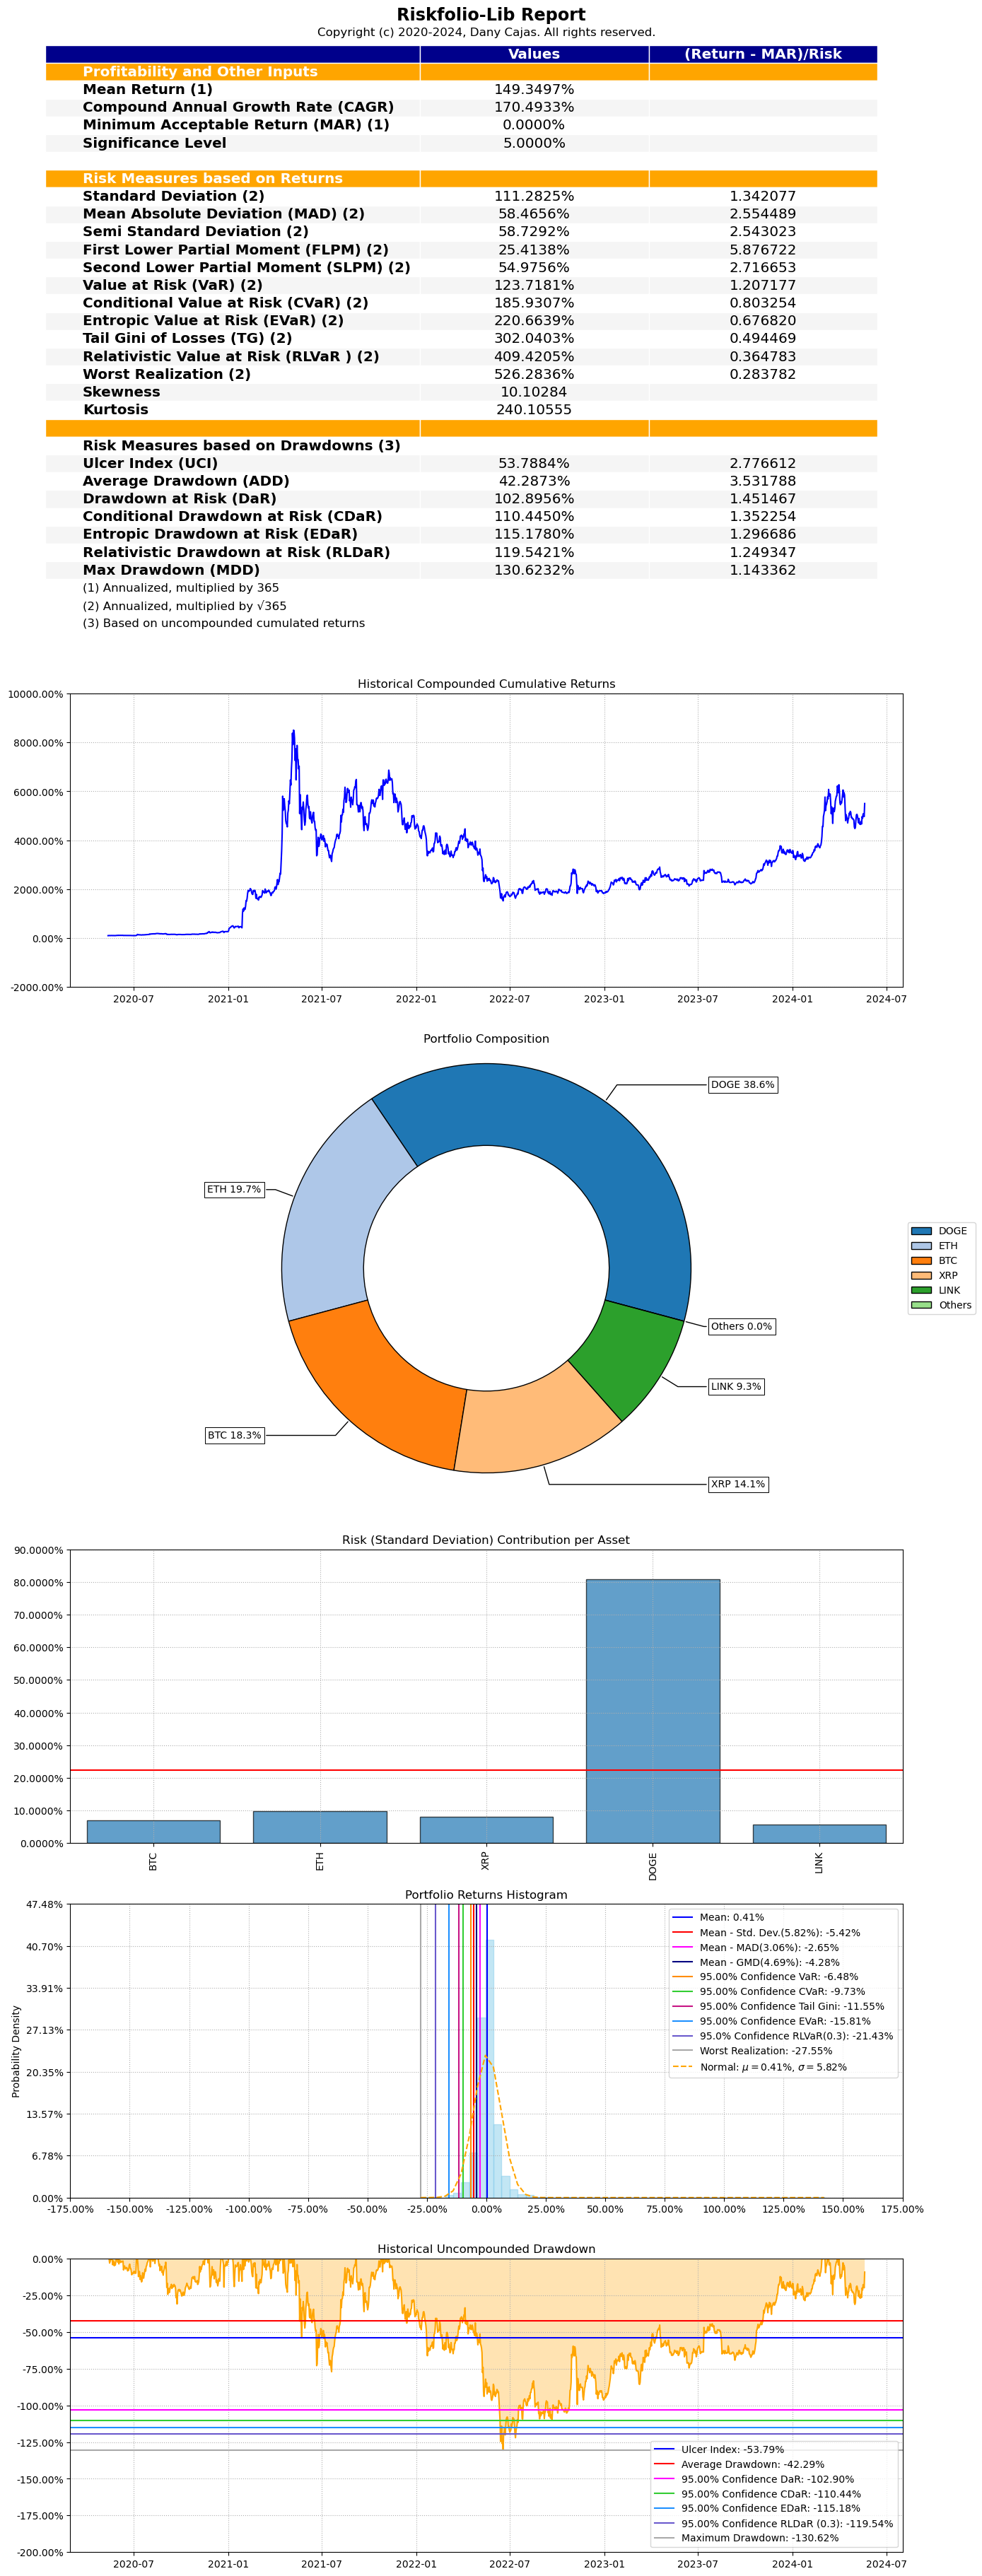

In [18]:
ax = rp.jupyter_report(returns,
                       w = w,
                       rm='MV',
                       rf=0,
                       alpha=0.05,
                       height=6,
                       width=14,
                       others=0.05,
                       nrow=25,
                       t_factor=365,
                       days_per_year=365)

In [19]:
def MDD_Abs(X):
    r"""
    Calculate the Maximum Drawdown (MDD) of a returns series
    using uncompounded cumulative returns.

    .. math::
        \text{MDD}(X) = \max_{j \in (0,T)} \left [\max_{t \in (0,j)}
        \left ( \sum_{i=0}^{t}X_{i} \right ) - \sum_{i=0}^{j}X_{i}  \right ]

    Parameters
    ----------
    X : 1d-array
        Returns series, must have Tx1 size.

    Raises
    ------
    ValueError
        When the value cannot be calculated.

    Returns
    -------
    value : float
        MDD of an uncompounded cumulative returns.

    """

    a = np.array(X, ndmin=2)
    if a.shape[0] == 1 and a.shape[1] > 1:
        a = a.T
    if a.shape[0] > 1 and a.shape[1] > 1:
        raise ValueError("returns must have Tx1 size")

    prices = np.insert(np.array(a), 0, 1, axis=0)
    NAV = np.cumsum(np.array(prices), axis=0)
    value = 0
    peak = -99999
    for i in NAV:
        if i > peak:
            peak = i
        DD = peak - i
        if DD > value:
            value = DD

    value = np.array(value).item()

    return value

MDD_Abs(returns['XRP'])

1.1960589762723974

In [20]:
rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model='Classic', rm='MV', obj='Sharpe', rf=0, l=0, hist=True)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
BTC,25.51%,25.51%,25.51%,25.51%,25.51%,25.51%,25.51%,25.51%,25.51%,25.51%,25.51%,25.51%,25.51%
ETH,35.88%,35.88%,35.88%,35.88%,35.88%,35.88%,35.88%,35.88%,35.88%,35.88%,35.88%,35.88%,35.88%
XRP,9.68%,9.68%,9.68%,9.68%,9.68%,9.68%,9.68%,9.68%,9.68%,9.68%,9.68%,9.68%,9.68%
DOGE,19.45%,19.45%,19.45%,19.45%,19.45%,19.45%,19.45%,19.45%,19.45%,19.45%,19.45%,19.45%,19.45%
LINK,9.48%,9.48%,9.48%,9.48%,9.48%,9.48%,9.48%,9.48%,9.48%,9.48%,9.48%,9.48%,9.48%


In [22]:
cum_returns = np.cumprod(1+returns) - 1
cum_returns

,BTC,ETH,XRP,DOGE,LINK
Date,,,,,
2020-05-12,0.023563,0.018286,0.018411,0.020721,0.029932
2020-05-13,0.077680,0.071434,0.038214,0.044758,0.048914
2020-05-14,0.131592,0.091636,0.046711,0.066722,0.059782
2020-05-15,0.084448,0.052228,0.024976,0.038541,0.024989
2020-05-16,0.090123,0.079415,0.030753,0.041442,0.048822
...,...,...,...,...,...
2024-05-16,6.583484,14.841461,1.657360,61.012847,3.326196
2024-05-17,6.795102,15.642845,1.699130,63.468710,3.533511
2024-05-18,6.782189,15.797920,1.686691,62.438461,3.549711


In [31]:
MDD_Abs(cum_returns['XRP'])

1.264805352513141

In [38]:
yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

assets = ['BTC-USD','ETH-USD','XRP-USD','DOGE-USD','LINK-USD']

# Define the start date
start_date = '2020-05-11'
end_date = '2024-05-21'

# Downloading data
data = yf.download(assets, start = start_date, end = end_date)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets
# Calculating returns
Y = data[assets].pct_change().dropna()
display(Y.head())

[*********************100%%**********************]  5 of 5 completed


/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in

,BTC-USD,ETH-USD,XRP-USD,DOGE-USD,LINK-USD
Date,,,,,
2020-05-12,2.3563%,2.0721%,1.8286%,2.9932%,1.8411%
2020-05-13,5.2872%,2.3549%,5.2193%,1.8430%,1.9445%
2020-05-14,5.0025%,2.1023%,1.8855%,1.0361%,0.8184%
2020-05-15,-4.1662%,-2.6418%,-3.6100%,-3.2830%,-2.0765%
2020-05-16,0.5233%,0.2793%,2.5838%,2.3252%,0.5636%


In [62]:
returns

,BTC,ETH,XRP,DOGE,LINK
Date,,,,,
2020-05-12,2.3563%,1.8286%,1.8411%,2.0721%,2.9932%
2020-05-13,5.2872%,5.2193%,1.9445%,2.3549%,1.8430%
2020-05-14,5.0025%,1.8855%,0.8184%,2.1023%,1.0361%
2020-05-15,-4.1662%,-3.6100%,-2.0765%,-2.6418%,-3.2830%
2020-05-16,0.5233%,2.5838%,0.5636%,0.2793%,2.3252%
...,...,...,...,...,...
2024-05-16,-1.5632%,-3.0268%,-0.6370%,-3.7865%,11.6756%
2024-05-17,2.7905%,5.0588%,1.5718%,3.9602%,4.7921%
2024-05-18,-0.1656%,0.9318%,-0.4609%,-1.5981%,0.3573%


In [59]:
import riskfolio as pf

# Building the portfolio object
port = pf.Portfolio(returns=Y, nea = 4)
# Select method and estimate input parameters:
# Method to estimate expected returns based on historical data
method_mu='hist'
# Method to estimate covariance matrix based on historical data
method_cov='hist' 
# Estimate mean and covariance based on historical data
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic(historical), BL(Black Litterman), FM(Factor Model) or BL_FM(Black litterman with factors)
rm = 'CVaR' # Risk measure used, there are 13 available risk measures
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,BTC-USD,ETH-USD,XRP-USD,DOGE-USD,LINK-USD
weights,18.2915%,38.6362%,19.7019%,9.2963%,14.0741%


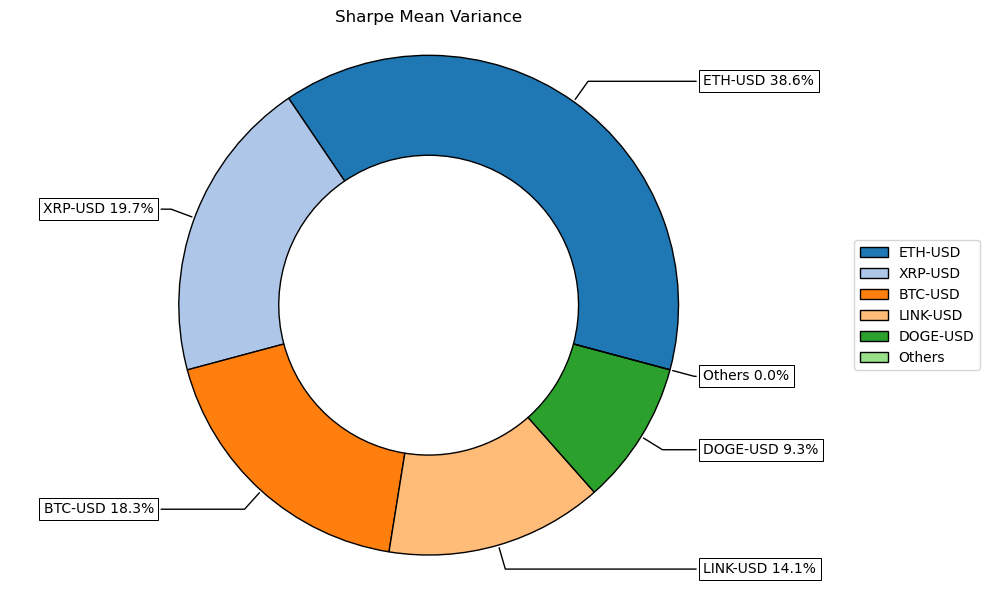

In [60]:
# Plotting the composition of the portfolio

ax = pf.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20", height=6, width=10, ax=None)